![Sizing Lab](https://raw.githubusercontent.com/SizingLab/sizing_course/main/laboratories/Lab-watt_project/assets/images/Baniere.png)

# Case study specification

*Written by Marc Budinger, INSA Toulouse, France*

We will now develop tools allowing:
- generate mission profiles corresponding to a new need for an urban transport line
- optimize certain mission profiles choices to minimize consumption

In order to have flexibility in the definition of the case studies, an object-oriented programming approach will be used.

### Electric vehicles

Different types of urban electric vehicles exist (tram, trolley bus, electric bus), we can define a general vehicle class wich can represent the multiple possible supports.

In [17]:
class vehicle:
    def __init__(self, MaxSpeed, MaxAcc,NumberPass,Weight,Crr,Cd,FrontArea):
        self.MaxSpeed = MaxSpeed # [m/s] maximal speed
        self.MaxAcc = MaxAcc # [m/s²] maximal acceleration
        self.NumberPass = NumberPass # [-] passenger capacity (3p/m²)
        self.Weight = Weight # [kg] effective weight (with passenger 62kg/p)
        self.Crr = Crr # [-] rolling resistance coefficient
        self.Cd = Cd # [-] drag coefficient
        self.FrontArea = FrontArea # [m²] frontal area
        self.Fmax = Weight*MaxAcc # [N] max traction force
        self.Pmax = self.Fmax*self.MaxSpeed # [W] max corner power


Here you will find some useful vehicle characteristics for the rest of the study.

| Attribute  | Tram      | Trolleybus      | Bus | Car (Tesla 3) |
|---    |:-:    |:-:    |:-:    |:-:    |
| Maximum operational speed     |  60 km/h     |  60 km/h     | 50 km/h | 100 km/h (1st gear) |
| Acceleration and braking      | 1.2 m/s²      |  1.2 m/s²     | 1.2 m/s² | 4.6 m/s² |
| Passenger capacity @ 3p/m²      | 220      | 138      | 95 | 4 |
| Vehicle effective weight @ 62 kg/p | 57049 kg | 27656 kg | 19500 kg |1800 kg  |
| Rolling resistance coefficient | 0.006 | 0.015 | 0.015 | 0.015 |
| Aerodynamic drag coefficient| 0.6 | 0.6 |0.6 | 0.23 | 
| Frontal area | 8.5 m² | 8.5 m² | 8.5 m²| 2.22 m² |



> **Exercice:** Define 4 instances of the  class `vehicle` corresponding to the vehicles above.

In [18]:
Tram = vehicle(MaxSpeed = 60*1e3/3600, MaxAcc=1.2,NumberPass=220,Weight=57049,Crr=0.006,Cd=0.6,FrontArea=8.5)
TrolleyBus = vehicle(60*1e3/3600,1.2,138,27656,0.015,0.6,8.5)
Bus = vehicle(50*1e3/3600,1.2,95,19500,0.015,0.6,8.5)
Car = vehicle(60*1e3/3600,4.6,4,1800,0.015,0.23,2.22)

### Generation and mission profile simulation

The objective now is to simulate the dynamic evolution of the main mechanical quantities (position, speed, acceleration, tractive effort, driving power) on typical sections of urban routes.

When a vehicle travels from point A (Starting point) to point B (Stopping point ) it generally passes through four stages namely:
- Accelerating mode
- Constant speed mode
- Coasting mode
- Braking mode

The control points for switching from one mode to another are defined in the following code using 3 parameters $k_1, k_2, k_3$ as shown in the figure below. 
![General Speed Profile](https://raw.githubusercontent.com/SizingLab/sizing_course/main/laboratories/Lab-watt_project/assets/images/GeneralspeedProfile.PNG)

The following code implements a control logic comprising the 4 phases defined previously and a numerical integration of the differential equation corresponding to the longitudinal dynamics of the vehicle.

> **Question:** What evolution should be added to take into account variations in altitude?

In [19]:
import numpy as np
from scipy import signal
from scipy.optimize import fmin_slsqp
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt
from scipy.integrate import odeint

class SimulSection:
    def __init__(self,Vehicle,Distance, MeanSpeed,BrakeRatioMax,dt):
        # Parameters definition
        self.Vehicle = Vehicle # vehicle parameters
        self.Distance = Distance # [m] distance to travel
        self.MeanSpeed = MeanSpeed # [m/s] Mean Speed < MaxSpeep
        self.TravelTime = self.Distance / self.MeanSpeed  # [s] Travel time
        self.BrakeRatioMax = BrakeRatioMax # [-], inferieur à 1, ratio de puissance de freinage / Puisssance d'acceleration
        self.rho = 1.25 # [kg/m3] air density
        self.g = 9.81 # [m/s²] gravity
        self.dt = dt # Time step for numerical solver
        
        # Tests sur les lois de mouvement
        # https://fr.wikipedia.org/wiki/Loi_de_mouvement
        
        if (MeanSpeed>=Vehicle.MaxSpeed):
           print("Mean Speed is to high : Mean Speed > Vehicle Max Speed") 
        
        # profil triangulaire : minimise l'acceleration
        #     amax = 4⋅xf/T2 ;    vmax = 2⋅xf/T ; amax = vmax / (T/2) ; vmean = vmax / 2
        #     amax = 4*vmean^2 / xf
        
        # Calcul de l'acceleration possible a pleine vitesse
        AmaxFullSpeed=(self.Vehicle.Fmax - 1/2*self.rho*self.Vehicle.Cd*self.Vehicle.FrontArea*self.Vehicle.MaxSpeed**2 - self.Vehicle.Weight*self.g*self.Vehicle.Crr)/self.Vehicle.Weight
        if (AmaxFullSpeed < 4*self.MeanSpeed / self.TravelTime):
            print("Vehicle Max Acceleration (depending of max force) is too low or travel distance too small or mean speed too small")
            
            
    # dynamic model for acceleration, coasting and braking
    def model(self, y,F):
        # state
        x, dxdt = y
        # System: acceleration calculation
        dxdt2 = (F-self.Vehicle.Crr*self.Vehicle.Weight*self.g*np.sign(dxdt)
                 -1/2*self.rho*self.Vehicle.Cd*self.Vehicle.FrontArea*dxdt**2**np.sign(dxdt))/self.Vehicle.Weight
        dydt = [dxdt, dxdt2]
        return dydt 

  
    # https://perso.crans.org/besson/publis/notebooks/Runge-Kutta_methods_for_ODE_integration_in_Python.html
    # solver numerique
        
    def solver(self, x):
        k1, k2, k3 = x
        dt=self.dt # [s] pas de temps pour l'integration
        t=0
        self.tsection = [0]
        self.xsection = [0]
        self.vsection = [0]
        self.asection = [0] 
        self.psection = [0]
        self.Fsection = [0]
        self.NRJsection = [0]
        NRJ=0
        
        y0 = np.array([0, 0]) 
        y= y0
        
      
        while (y[1]>=0):
            # Traction/Braking force
            if (y[0]<k1*k2*k3*self.Distance):
                F=self.Vehicle.Fmax
                dydt = self.model(y, F)
            elif (y[0]<k3*k2*self.Distance):
                F=self.Vehicle.Crr*self.Vehicle.Weight*self.g+1/2*self.rho*self.Vehicle.Cd*self.Vehicle.FrontArea*y[1]**2
                dydt = [y[1], 0]
            elif (y[0]<k3*self.Distance):
                F=0
                dydt = self.model(y, F)
            else:
                F=-self.Vehicle.Fmax
                dydt = self.model(y, F)
                
            self.Fsection = self.Fsection + [F]    
                
            # Euler integration de la postion y[0] et de la vitesse y[1]
            y = y + dt * np.array(dydt)

            t = t + dt
            NRJ = NRJ+y[1]*F*dt

           
            self.tsection = self.tsection + [t]
            self.xsection = self.xsection + [y[0]]
            self.vsection = self.vsection + [y[1]]
            self.psection = self.psection + [y[1]*F]
            self.asection = self.asection + [dydt[1]] 
            self.NRJsection = self.NRJsection + [NRJ]
            
    
    def plot(self):
        fig, axs = plt.subplots(3,2)
        axs[0,0].plot(self.tsection,self.xsection,'b-',label='Simulation')
        axs[0,0].plot(self.tsection,self.Distance*np.ones(len(self.tsection)),'g-',label='Specification')
        axs[0,0].set_ylabel("Position (m)")
        axs[0,0].legend()
        axs[0,0].grid()
        axs[1,0].plot(self.tsection,self.vsection,'b-', label='Simulation')
        axs[1,0].plot(self.tsection,self.MeanSpeed*np.ones(len(self.tsection)),'g-',label='Specification')
        axs[1,0].plot(self.tsection,np.mean(self.vsection)*np.ones(len(self.tsection)),'r--',label='Mean')
        axs[1,0].set_ylabel("Speed (m/s)")
        #axs[1].sharex(axs[0])
        axs[1,0].grid()    
        axs[1,0].set_xlabel('Time (s)')    
        axs[0,1].plot(self.tsection,self.Fsection,'b-')
        axs[0,1].set_ylabel("Force (N)")
        axs[0,1].grid()
        
        axs[2,0].plot(self.tsection,self.asection,'b-')
        axs[2,0].set_ylabel("Acceleration (m/s²)")
        axs[2,0].grid()
        axs[2,0].set_xlabel('Time (s)')    
        
        axs[1,1].plot(self.tsection,np.array(self.psection)*1e-3,'b-')
        axs[1,1].set_ylabel("Power (kW)")
        axs[1,1].grid()
        axs[1,1].set_xlabel('Time (s)')   
        
        axs[2,1].plot(self.tsection,np.array(self.NRJsection)*1e-3,'b-')
        axs[2,1].set_ylabel("Energy (kJ)")
        axs[2,1].grid()
        axs[2,1].set_xlabel('Time (s)') 
        fig.tight_layout()

    def ConsumptionPerPax(self,x):
        Trajet.solver(x)
        print("Consumption per passenger: %.2f kJ/(Pax.km)"%(Trajet.NRJsection[-1]/Trajet.Vehicle.NumberPass/Trajet.Distance))
        return (Trajet.NRJsection[-1]/Trajet.Vehicle.NumberPass/Trajet.Distance) 
    


Example of use of the previous code:

Consumption per passenger: 14.35 kJ/(Pax.km)


14.35180016858578

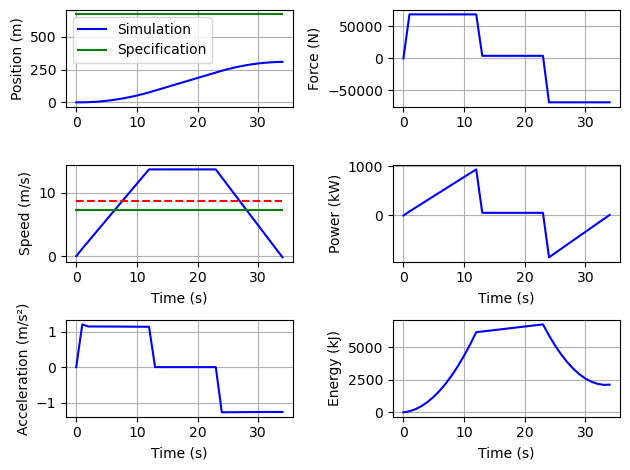

In [23]:
# Definition of the section under study
Trajet = SimulSection(Vehicle=Tram, Distance=670, MeanSpeed=26*1e3/3600,BrakeRatioMax=0.6,dt=1)

# Definition of k1, k2, k3 parameters
#X=[0.036125972011676784, 1, 0.9638740279883232]
X=[0.33, 1, 0.33]

# Profile integration, plotting and consummption per passenger evaluation
Trajet.solver(X)
Trajet.plot()
Trajet.ConsumptionPerPax(X)

A extrema case is a triangular profile without constant speed and coasting modes which minimizes acceleration and inertial driving force.
> **Question:** Give the relationship between acceleration, average speed and distance traveled if we assume the acceleration and braking phases are perfectly linear.


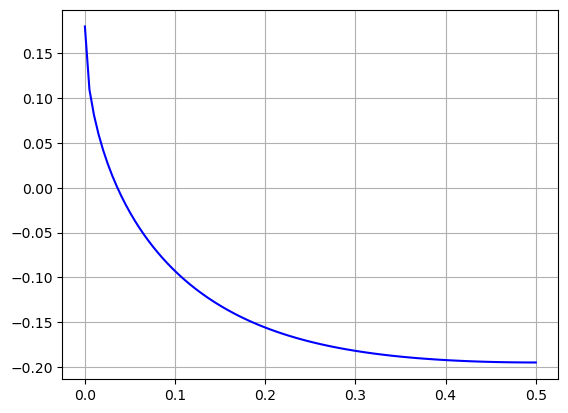

In [24]:
# Parameters calculation
# on pose x = sqrt(k1)
from scipy.optimize import root

Trajet = SimulSection(Tram, 670, 26*1e3/3600,1,1)
a = Trajet.MeanSpeed/(2*Trajet.Vehicle.MaxAcc*Trajet.Distance)**0.5

f = lambda x: a+(x*(1-x))**1.5-(x*(1-x))**0.5

X=np.linspace(0,0.5,100)

plt.plot(X,f(X),'b-')
plt.grid()
plt.show()

sol=root(f, 0.1)

k1=float(sol.x)


[0.036125972011676784, 1, 0.9638740279883232]
Consumption per passenger: 20.44 kJ/(Pax.km)


20.444745494590236

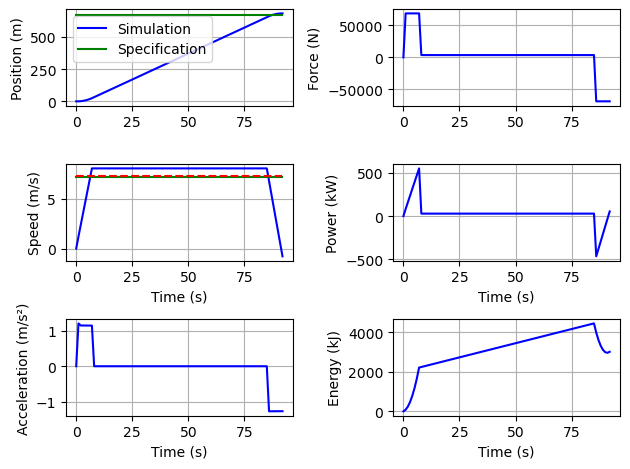

In [25]:
k3=1-k1

X=[k1,1,k3]
print(X)
Trajet.solver(X)
Trajet.plot()
Trajet.ConsumptionPerPax(X)

> **Questions:** Is this type of profile the one that minimizes the energy consumed ? What rules do you recommend to minimize the energy consumed?

### Optimizing power consumption using speed profile

In a more general case and contrary to the previous hypothesis, the braking power is not necessarily identical to that possible during acceleration. The following article shows that it is possible to optimize the consumption of a tram:
> Tian, Z., Zhao, N., Hillmansen, S., Roberts, C., Dowens, T., & Kerr, C. (2019). SmartDrive: Traction energy optimization and applications in rail systems. IEEE Transactions on Intelligent Transportation Systems, 20(7), 2764-2773.

The previous class is now extended to allow optimization of variables $k_1, k_2, k_3$ in order to minimize energy consumption (even with braking power lower than acceleration power).

In [26]:
class OptimSection(SimulSection):   
    # Gradient optimization
    def objectif(self, x):
        self.solver(x)
        NRJmin = self.xsection[-1]*self.Vehicle.Weight*self.g*self.Vehicle.Crr
        return (self.NRJsection[-1]/NRJmin)
                
    def contraintes(self, x):
        self.solver(x)
        TimeTrajet = self.Distance / self.MeanSpeed  
        PowerAccBrakeRatio = abs(min(self.psection))/max(self.psection)
        print(PowerAccBrakeRatio)
        # contraintes en distance, vitesse moyenne (ou duree de trajet, vitesse au freinage), ratio puissance freinage / acc 
        return [(self.xsection[-1]-self.Distance)/self.Distance, (TimeTrajet-self.tsection[-1])/TimeTrajet, 
                self.BrakeRatioMax-PowerAccBrakeRatio ]    
      
    
    def optimize(self,x0):
        
        Xbound= [(0.0, 0.3), (0.1, 1), (0.5,.99)]
        
        Xopt=fmin_slsqp(func=self.objectif, x0=x0, f_ieqcons = self.contraintes, bounds=Xbound, epsilon=1e-2)
                
        return Xopt
    
    # Differential evolution optimization
    
    def objectifG(self, x):
        self.solver(x)
        NRJmin = self.xsection[-1]*self.Vehicle.Weight*self.g*self.Vehicle.Crr
        pen=0
        TimeTrajet = self.Distance / self.MeanSpeed  
        PowerAccBrakeRatio = abs(min(self.psection))/max(self.psection)
        VecC=[(self.xsection[-1]-self.Distance)/self.Distance, (TimeTrajet-self.tsection[-1])/TimeTrajet, self.BrakeRatioMax-PowerAccBrakeRatio ]      
        for C in VecC:
            if (C<0):
                pen=pen-1e2*C
        
        return (self.NRJsection[-1]/NRJmin+pen)
    
    
    
    def optimizeG(self,x0):
        Xbound= [(0.0, 0.3), (0.1, 1), (0.5,0.99)]
        res=differential_evolution(func=self.objectifG, x0=x0, bounds=Xbound)
        print(res)
        return res.x
    


The usage of the class is quite simular that the previous one, except an `optimize`which enable to optimize the $k_1, k_2, k_3$ set of profile parameter: 

     fun: 1.1158089318082165
 message: 'Optimization terminated successfully.'
    nfev: 1489
     nit: 32
 success: True
       x: array([0.21303764, 0.26448796, 0.98130867])
Optimal vector : [0.21303764 0.26448796 0.98130867]
0.5338101629137351
Constraints vector : [0.0010935971716579463, 0.00020729684908794098, 0.06618983708626491]
Consumption per passenger: 17.05 kJ/(Pax.km)


17.04944044980444

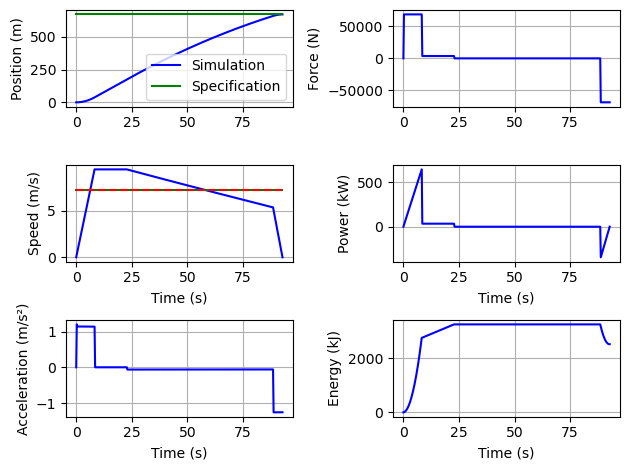

In [27]:
# Definition of the section under study
Trajet = OptimSection(Vehicle=Tram, Distance=670, MeanSpeed=26*1e3/3600,BrakeRatioMax=0.6,dt=0.25)

# Initial variables vector
X=[0.036125972011676784, 1, 0.9638740279883232]

# Optimization
Xopt=Trajet.optimizeG(X) # Global optimization with differential evolution algorithm

# Xopt=Trajet.optimize(X) # Opitmization with gradient algorithm

# print and plot results
print("Optimal vector :",Xopt)
print("Constraints vector :", Trajet.contraintes(Xopt))

Trajet.solver(Xopt)
Trajet.plot()
Trajet.ConsumptionPerPax(Xopt)

> **Question:** Compare this optimized profile to a profile with only 3 segments: maximum acceleration, constant speed, maximum deceleration. Evaluate effect of specifications (distance, braking power/acceleration power ratio).

### Different vehicules comparison

> **Exercice:** For the same travel (distance, main speed) compare the consumption of different vehicles (tramway, tram, bus, car). The function `ConsumptionPerPax` return and print the consumption per km and per passenger. Compare the results with this [publication](https://reporterre.net/Taxis-volants-aux-JO-un-avis-defavorable-sur-le-projet). 







Calculation of energy consumption of different vehicles: 

Tramway :
     fun: 1.2943682600385298
 message: 'Optimization terminated successfully.'
    nfev: 1444
     nit: 31
 success: True
       x: array([0.11366347, 0.38214542, 0.98814655])
Consumption per passenger: 20.18 kJ/(Pax.km)
----
Trolleybus :
     fun: 1.1396852632064673
 message: 'Optimization terminated successfully.'
    nfev: 1039
     nit: 22
 success: True
       x: array([0.08891115, 0.62392538, 0.98838631])
Consumption per passenger: 33.77 kJ/(Pax.km)
----
Bus :
     fun: 1.1554437831959297
 message: 'Optimization terminated successfully.'
    nfev: 1174
     nit: 25
 success: True
       x: array([0.05995131, 0.76414395, 0.98864647])
Consumption per passenger: 35.30 kJ/(Pax.km)
----
Car :
     fun: 1.522255018926166
 message: 'Optimization terminated successfully.'
    nfev: 1804
     nit: 39
 success: True
       x: array([6.78552119e-04, 9.99584873e-01, 9.87743031e-01])
Consumption per passenger: 102.08 kJ/(Pax

102.08184402614765

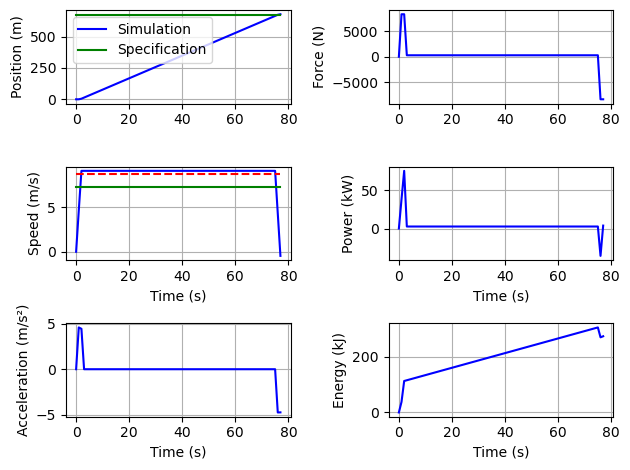

In [28]:
print("Calculation of energy consumption of different vehicles: ")
print("")
print("Tramway :")
Trajet = OptimSection(Tram, 670, 26*1e3/3600,0.5,1)
X=[0.036125972011676784, 1, 0.9638740279883232]
Xopt=Trajet.optimizeG(X)
Trajet.ConsumptionPerPax(Xopt)
print("----")

print("Trolleybus :")
Trajet = OptimSection(TrolleyBus, 670, 26*1e3/3600,0.5,1)
X=[0.036125972011676784, 1, 0.9638740279883232]
Xopt=Trajet.optimizeG(X)
Trajet.ConsumptionPerPax(Xopt)
print("----")

print("Bus :")
Trajet = OptimSection(Bus, 670, 26*1e3/3600,0.5,1)
X=[0.036125972011676784, 1, 0.9638740279883232]
Xopt=Trajet.optimizeG(X)
Trajet.ConsumptionPerPax(Xopt)
print("----")

print("Car :")
Trajet = OptimSection(Car, 670, 26*1e3/3600,0.5,1)
X=[0.036125972011676784, 1, 0.9638740279883232]
Xopt=Trajet.optimizeG(X)
Trajet.plot()
Trajet.ConsumptionPerPax(Xopt)

### Homework

Read the following paper:
> Jaafar, A., Sareni, B., Roboam, X., & Thiounn-Guermeur, M. (2010, September). Sizing of a hybrid locomotive based on accumulators and ultracapacitors. In 2010 IEEE Vehicle Power and Propulsion Conference (pp. 1-6). IEEE. [[pdf](https://raw.githubusercontent.com/SizingLab/sizing_course/main/laboratories/Lab-watt_project/assets/papers/Sizing_of_a_hybrid_locomotive_based_on_accumulators_and_ultracapacitors.pdf)]